# Part 0: Requirements

In [1]:
# Allow python to import modules from src folders
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import ast
from collections import Counter
sys.path.append("src/")

from preprocessing.load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

## Download data  
Please uncomment the following line to download data

In [ ]:
# %run src/preprocessing/download_dataset.py

# Part I: Load, explore and join datasets

## CMU dataset

We load the 4 `.tsv` and `.txt` files of the CMU dataset into 4 different dataframes

In [12]:
characters_df = load_characters_df()
movies_df = load_movies_df()
plot_df = load_plot_df()
tvtropes_df = load_tvtropes_df()

### Characters

The characters dataframe comes from the CMU movies dataset. This dataframe describes movie characters and provides information about the actor who played the corresponding character. Here is a sample of this dataframe :

In [13]:
characters_df.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
106703,12260598,/m/027j9wd,2009-07-01,Gazelle,1978-06-07,M,1.850,NaN,Bill Hader,31.0,/m/0h2kk2m,/m/0h2kk2s,/m/086nl7
76028,34353767,/m/0h_dply,1989-07-01,NaN,1960-12-12,M,NaN,NaN,Lee Gyeung-young,28.0,/m/0mzkxpb,NaN,/m/0b74vbp
339459,36421828,/m/0k8cc_l,1998,NaN,1960-10-21,M,NaN,/m/048sp5,Mukesh,37.0,/m/0mzkpwq,NaN,/m/0bwqq2
63752,13443734,/m/03c5hrk,2007-09-21,NaN,NaN,NaN,NaN,NaN,Graham Feeley,NaN,/m/0gckzj9,NaN,/m/0gbwxvh
282121,3448857,/m/09c_lj,1997-12-25,Agent Gus Anders,1945-12-17,M,1.829,/m/0x67,Ernie Hudson,52.0,/m/062v1cp,/m/0h5vjt1,/m/03fnyk


In [14]:
total_characters = len(characters_df)
print(f"Number of characters loaded: {total_characters}")
print(f"Number of unique movies: {len(characters_df['wiki_movie_id'].unique())}")
print(f"Number of unique actors: {len(characters_df['freebase_actor_id'].unique())}", end="\n\n")

print(f"Percentage of missing gender: {characters_df['actor_gender'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing height: {characters_df['actor_height'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing ethnicity: {characters_df['actor_ethnicity'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing age upon release: {characters_df['release_actor_age'].isna().sum()/total_characters*100:.2f}%", end="\n\n")

print(f"Number of character records for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()])}")
print(f"Number of unique actors for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()]['freebase_actor_id'].unique())}")

Number of characters loaded: 450669
Number of unique movies: 64330
Number of unique actors: 135761

Percentage of missing gender: 10.12%
Percentage of missing height: 65.65%
Percentage of missing ethnicity: 76.47%
Percentage of missing age upon release: 35.08%

Number of character records for which ethnicity is known: 106058
Number of unique actors for which ethnicity is known: 8151


We can first notice that a great percentage of actor's ethnicity is missing. This may become a problem when we study the impact of actors' ethnicity on the success of a movie. Let's investigate a bit.

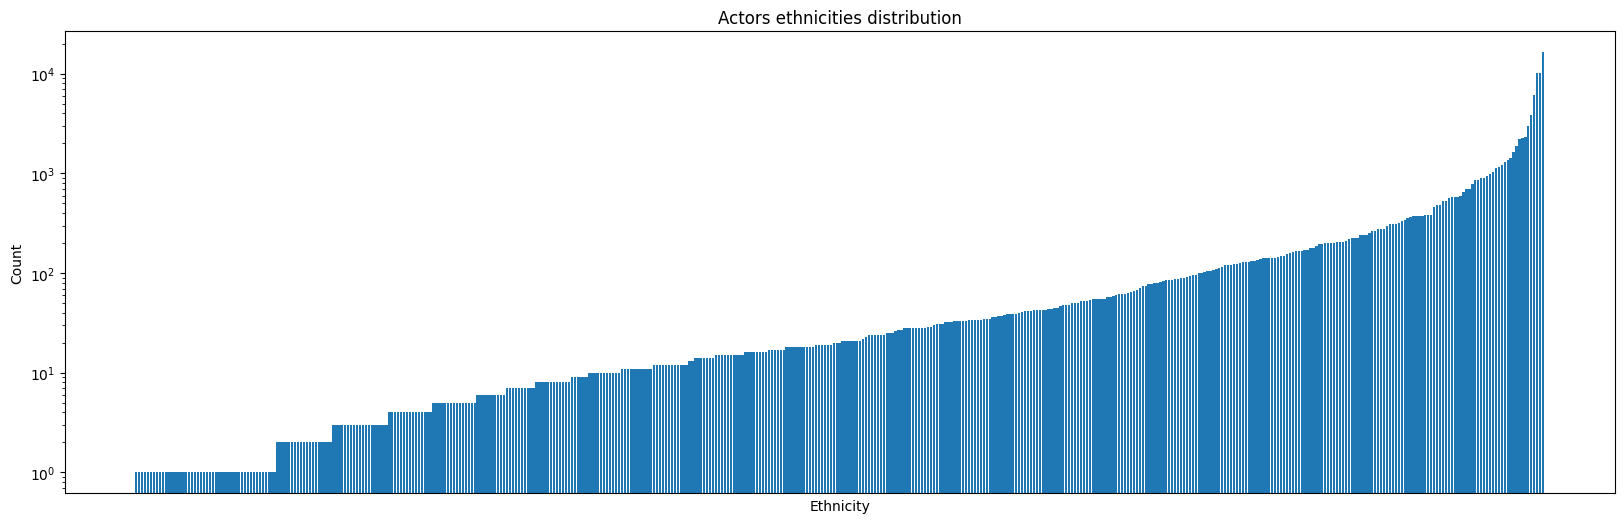

In [15]:
actors_ethnicities = characters_df[['freebase_actor_id', 'actor_ethnicity']].dropna().groupby(by='actor_ethnicity').count()
actors_ethnicities = actors_ethnicities.sort_values(by='freebase_actor_id')

plt.figure(figsize=(20,6))
plt.bar(actors_ethnicities.index, actors_ethnicities['freebase_actor_id'], label='')
plt.title("Actors ethnicities distribution")
plt.yscale('log')
plt.xticks([])
plt.ylabel("Count")
plt.xlabel("Ethnicity")
plt.show()

As shown, the ethnicities distribution is very heterogeneous. Some ethnicities have only one representative whereas others have more than thousands elements. During analysis, we must be careful on our conclusions as variance gets higher for the ethnicities with fewer representatives. Fortunately, we can quantify uncertainty in our results using tools like p-value and confidence interval.

### Movies

The movies dataframe also comes from the CMU dataset and provides information about movies such as its origins, runtime and box office.

In [16]:
movies_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres
33985,26471073,/m/0bbx2_s,Jackal of Nahueltoro,1969-06,NaN,95.0,{'/m/06nm1': 'Spanish Language'},"{'/m/0b90_r': 'Mexico', '/m/01p1v': 'Chile'}","{'/m/0lsxr': 'Crime Fiction', '/m/02wtdps': 'C..."
42536,10774002,/m/02qpl0_,Congo Bill,NaN,NaN,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02kdv5l': 'Action', '/m/03k9fj': 'Adventu..."
14094,28373852,/m/0crfz50,Haškovy povídky ze starého mocnářství,1952,NaN,89.0,{'/m/01wgr': 'Czech Language'},{'/m/01mk6': 'Czechoslovakia'},{'/m/05p553': 'Comedy film'}
3189,36402289,/m/0k9bc06,Njai Dasima,1929-11,NaN,NaN,"{'/m/06ppq': 'Silent film', '/m/097kp': 'Indon...",{'/m/03ryn': 'Indonesia'},"{'/m/06ppq': 'Silent film', '/m/07s9rl0': 'Dra..."
81022,19273389,/m/04ljckn,Made in Paris,1966,NaN,103.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/06cvj': 'Romantic comedy'}


In [19]:
total_movies = len(movies_df)
print(f"Number of movies loaded: {total_movies}")
print(f"Percentage of missing box office revenue: {movies_df['box_office'].isna().sum()/total_movies*100:.2f}%")
print(f"Number of movies for which we have matching character data: {len(movies_df.merge(characters_df, how='inner', on=['wiki_movie_id', 'freebase_movie_id'])['freebase_movie_id'].unique())}")

Number of movies loaded: 81741
Percentage of missing box office revenue: 89.72%
Number of movies for which we have matching character data: 64330


A great proportion of box office revenue data is missing (almost 90%). This makes sense as lots of movies are not shown in cinemas such as TV movies, short movies. Indeed, to get a movie to the box office, one needs to work with studios or convince distributors to distribute the movie.

Thus, using box office as a way to measure a movie's performance may be biased because we already filter a specific type of movie. Furthermore, box office does not necessarily reflect the quality of a movie. Indeed some movies may not get a high box office revenue because of a lack of advertising. To fix this issue, we will use users rating from the IMDb database.

In [20]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)

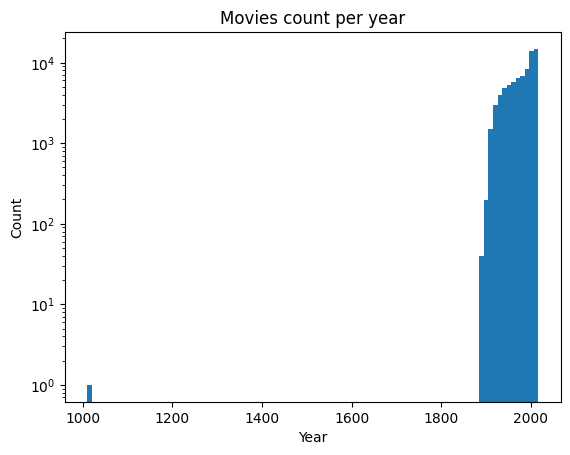

In [21]:
plt.hist(movies_df['movie_release_year'], bins=100)
plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

We notice that a movie has been produced 700 years before the invention of potography ! Let's investigate:

In [22]:
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index
movies_df.loc[wrong_dates]

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{'/m/02hwyss': 'Turkish Language', '/m/02h40lc...",{'/m/01znc_': 'Turkey'},"{'/m/0lsxr': 'Crime Fiction', '/m/02n4kr': 'My...",1010.0


By googling the movie's name, we find that `Hunting season` should be released in 2010 (instead of 1010). This is obviously a typo and 1010 should be replaced by 2010.

In [23]:
# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

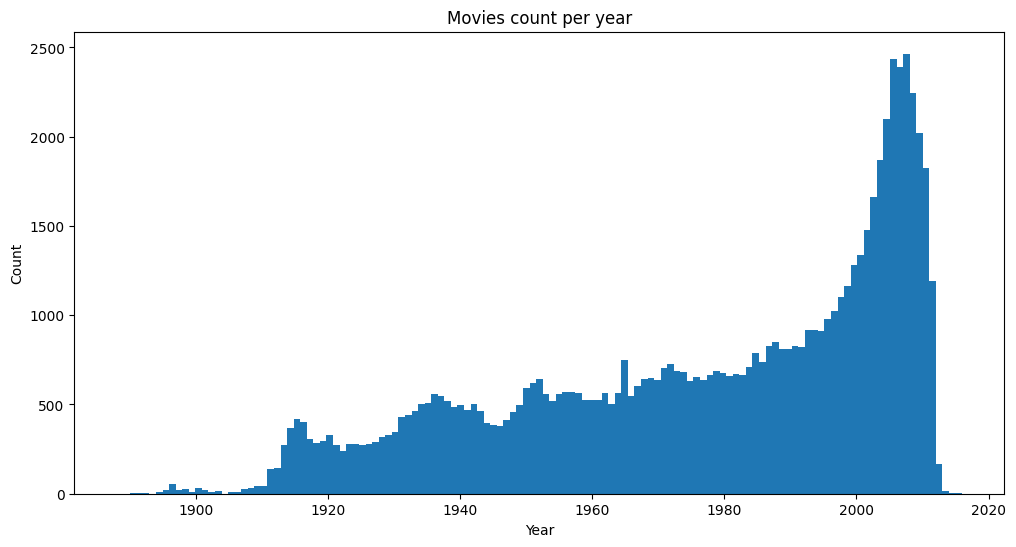

In [24]:
n_years = len(movies_df['movie_release_year'].dropna().unique())

plt.figure(figsize=(12, 6))
plt.hist(movies_df['movie_release_year'], bins=n_years)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

There are significantly more movies released after 1990 than before in our dataset.

### Plot

The plot dataframe comes from the CMU dataset and provides a summary of the plot of a given movie.

In [25]:
plot_df.sample(5)

,wiki_movie_id,plot_summary
25286,27904601,Thomas Archer's life changes due to a horrifi...
41050,35818387,"Four stories, four dramatic destinies about re..."
33237,20678499,"Set in late 19th century Vienna, the story foc..."
29297,22114003,"In 1906 San Francisco, Frisco Jenny Sandoval ,..."
10427,9612611,"Mysterious pilot, The Eagle, attempts to sabot..."


In [26]:
total_plot = len(plot_df)
print(f"Number of plot summaries loaded: {total_plot}")

Number of plot summaries loaded: 42303


### Tropes

The tvtropes dataframe is the one used by the CMU researchers to validate their personas learning algorithm. Unfortunately, this dataset does not contain a lot of tvtropes and can not be used for our analysis. Thus we need other databases to get the persona of movie characters.

In [27]:
tvtropes_df.sample(5)

,trope_name,character_data
279,granola_person,"{'char': 'Lotte Schwartz', 'movie': 'Being Joh..."
489,warrior_poet,"{'char': 'Broken Sword', 'movie': 'Hero', 'id'..."
68,byronic_hero,"{'char': 'Brand Hauser', 'movie': 'War Inc.', ..."
207,dumb_blonde,"{'char': 'Suzanne Stone Maretto', 'movie': 'To..."
210,dumb_blonde,"{'char': 'Lina Lamont', 'movie': 'Singin' in t..."


In [28]:
total_tropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tropes}")

Number of tropes loaded: 501


## IMDB dataset

We load the 4 `.tsv` files of the IMDB dataset into 4 different dataframes

In [29]:
imdb_ratings_df = load_imdb_ratings()
imdb_title_df = load_imdb_title_basics()
imdb_principals_df = load_imdb_title_principals()
imdb_people_df = load_imdb_person_basics()

### Ratings

First let's explore the ratings dataframe.

In [30]:
imdb_ratings_df.sample(5)

,tconst,averageRating,numVotes
87588,tt0117351,5.7,1180
11810,tt0027865,6.5,63
1052594,tt3690888,7.7,8
787217,tt1745004,6.8,33
428354,tt0908295,8.8,10


We have 1368573 movies for which we have a rating.


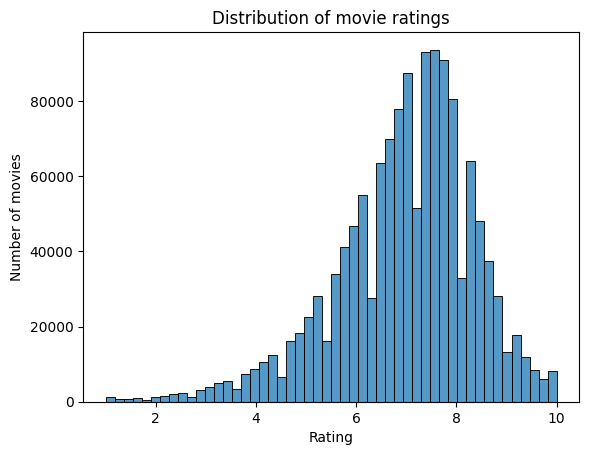

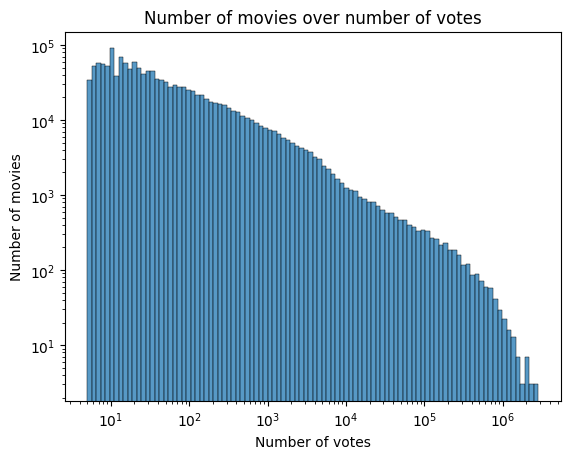

In [36]:
total_ratings = len(imdb_ratings_df)
print(f"We have {total_ratings} movies for which we have a rating.")

# Check the distribution of grades
sns.histplot(data=imdb_ratings_df, x="averageRating", bins=50)

plt.title("Distribution of movie ratings")
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.show()

# Check the distribution of votes
sns.histplot(data=imdb_ratings_df, x="numVotes", bins=100, log_scale=True)
plt.yscale("log")

plt.title("Number of movies over number of votes")
plt.xlabel("Number of votes")
plt.ylabel("Number of movies")
plt.show()

### Title

In [37]:
imdb_title_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
5851,tt0005922,movie,The Pretty Sister of Jose,The Pretty Sister of Jose,0,1915,\N,50,"Drama,Romance"
8726740,tt6447436,movie,El Caído del Cielo,El Caído del Cielo,0,2016,\N,\N,\N
121726,tt0125030,movie,Calling Paul Temple,Calling Paul Temple,0,1948,\N,92,"Crime,Mystery"
1785461,tt1147488,movie,Carlos Fuentes... Identidad y genio,Carlos Fuentes... Identidad y genio,0,2007,\N,52,"Biography,Documentary"
213560,tt0222936,movie,Le capitaine Santé et les 4 groupes d'aliments,Le capitaine Santé et les 4 groupes d'aliments,0,1990,\N,\N,\N


In [38]:
# Remove adult content
imdb_title_df = imdb_title_df[imdb_title_df["isAdult"].astype(int) == 0]

In [39]:
total_title = len(imdb_title_df)
print(f"We have {total_title} movie titles")

We have 652869 movie titles


### Principals

In [40]:
imdb_principals_df.sample(5)

,tconst,ordering,nconst,category,job,characters
43196975,tt3721064,5,nm6492225,writer,manga,\N
24365125,tt15544556,4,nm12965942,producer,producer,\N
6531677,tt0875947,1,nm2281916,actor,\N,"[""Kamen Rider Kabuto"",""Souji Tendou""]"
55433967,tt8678374,10,nm0140092,writer,\N,\N
26025650,tt16380010,6,nm10053110,writer,adaptation,\N


In [42]:
total_principals = len(imdb_principals_df)
print(f"We have {total_principals} principals records")
print(f"We have {len(imdb_principals_df['category'].unique())} categories")
print(f"We have {len(imdb_principals_df['nconst'].unique())} unique persons", end="\n\n")

missing_characters = len(imdb_principals_df[imdb_principals_df['characters'] == "\\N"])
print(f"We have {missing_characters/total_principals*100:.2f}% of missing characters")

We have 59057327 principals records
We have 12 categories
We have 5179687 unique persons

We have 51.89% of missing characters


### People

In [43]:
imdb_people_df.sample(5)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
9949620,nm6115662,Louis Meunier,\N,\N,actor,tt1952642
9802614,nm5921481,Nathaniel Anozie,\N,\N,"visual_effects,animation_department","tt0848537,tt6182908,tt1985949,tt6095472"
9075229,nm5059701,Gijs Kok,\N,\N,miscellaneous,tt2124554
2182775,nm11333346,Hana Jirku,\N,\N,actress,tt11097018
11751965,nm8456279,Shawn C. Smith,\N,\N,camera_department,tt6082850


In [44]:
total_people = len(imdb_people_df)
print(f"We have {total_people} people records")
print(f"We have {len(imdb_people_df['nconst'].unique())} unique persons")
print(f"We have {len(imdb_people_df[(imdb_people_df['primaryProfession'] == 'actor') | (imdb_people_df['primaryProfession'] == 'actress')])} unique actors")

We have 13007226 people records
We have 13007226 unique persons
We have 3869848 unique actors


### Movie titles with ratings

In [45]:
imdb_title_with_rating = imdb_title_df.merge(imdb_ratings_df, on='tconst', how='inner')
imdb_title_with_rating.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
209870,tt21342302,movie,Vala,Vala,0,2022,\N,\N,Thriller,7.6,9
91932,tt0232235,movie,Orfani se xena heria,Orfani se xena heria,0,1962,\N,83,Drama,4.8,19
160249,tt12196058,movie,Paird,Paird,0,2019,\N,106,"Action,Adventure,Animation",8.8,14
46812,tt0086103,movie,Phatik Chand,Phatik Chand,0,1983,\N,103,"Adventure,Crime,Drama",7.7,154
130877,tt0456743,movie,The Ghost Lovers,Yan nu huan hun,0,1974,\N,92,"Drama,Horror,Romance",5.4,100


In [46]:
total_movies_w_rating = len(imdb_title_with_rating)
print(f"We have {total_movies_w_rating} movies with ratings")

We have 295284 movies with ratings


There is more than one quarter of a million movies for which we have at least one rating. We have clearly much more data to work with than with box office revenue. Furthermore, there is a substantial amount of movies who have at least a few hundreds votes. This will allow us to get better confidence interval and reduce uncertainty in our analysis.

## Merge CMU movies and plot summaries with IMDB titles and ratings

The translation dataframe from wikidata, which includes both the IMDB id and the Freebase id, enables us to combine the IMDB dataset with the CMU dataset

In [47]:
translation_id = load_translation_df()

In [48]:
imdb_title_with_rating_translated = imdb_title_with_rating.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_title_with_rating_translated = imdb_title_with_rating_translated.drop(["imdb_id"], axis=1)

In [49]:
cmu_movies_w_imdb_rating = imdb_title_with_rating_translated.merge(movies_df, how='inner', left_on='freebase_id', right_on='freebase_movie_id').copy()

In [50]:
# Enriching CMU data
# IMDB start year has no missing data, so we insert it into "NaN" fields of "movie_release_date" and drop "startYear"
missing_years = cmu_movies_w_imdb_rating[cmu_movies_w_imdb_rating['movie_release_date'].isna()].index
cmu_movies_w_imdb_rating.loc[missing_years, 'movie_release_date'] = cmu_movies_w_imdb_rating.loc[missing_years, 'startYear']

In [51]:
# We have MANY depulicated attributes
# We evaluated for each pair which column had more missing data and dropped it in favor of the other
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop(["freebase_movie_id", "titleType", "isAdult", "endYear", "primaryTitle", "originalTitle", "movie_release_year", "movie_runtime", "startYear"], axis=1)

In [52]:
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop_duplicates("tconst")
print(f"The merged dataframe contains {len(cmu_movies_w_imdb_rating)} movies with corresponding ratings")

The merged dataframe contains 44476 movies with corresponding ratings


In [53]:
# Add summaries
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.merge(plot_df, on="wiki_movie_id", how="left")

In [55]:
cmu_movies_w_imdb_rating.sample(5)

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
12273,tt0056229,112,"Family,Sci-Fi",5.9,47,/m/0gtt24n,31804316,Masters of Venus,1962-09,NaN,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/06n90': 'Science Fiction'},NaN
38100,tt0832313,76,"Documentary,War",7.5,80,/m/080lgdn,24542444,Nice Bombs,2009,NaN,{},{'/m/09c7w0': 'United States of America'},"{'/m/0cshrf': 'Political cinema', '/m/03g3w': ...","In January 2004, shortly after officially beco..."
6671,tt0038913,87,Drama,8.0,7932,/m/0gdy_9,6616873,Shoeshine,1946,NaN,"{'/m/02bjrlw': 'Italian Language', '/m/02h40lc...",{'/m/03rjj': 'Italy'},"{'/m/07s9rl0': 'Drama', '/m/01j1n2': 'Coming o...","Two friends, Giuseppe and Pasquale, test-ride ..."
35862,tt0436833,106,Drama,4.8,268,/m/028bjtg,9480220,Colour Blossoms,2004-10-28,NaN,"{'/m/03_9r': 'Japanese Language', '/m/0459q4':...","{'/m/03h64': 'Hong Kong', '/m/0d05w3': 'China'}","{'/m/0hn10': 'LGBT', '/m/07s9rl0': 'Drama', '/...",NaN
8667,tt0044905,102,"Drama,History",6.7,1397,/m/06l8bt,2087175,The Miracle of Our Lady of Fatima,1952-08-20,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/04p5fxn': 'Christian film', '/m/07s9rl0':...","It is 1917, and Portugal is feeling the aftere..."


## Merge IMDB people and principals
We now focus on characters and actors. We merge the two dataframes from IMDB and keep records of interest i.e for which the movie is in the collection above.

In [56]:
titles_of_interest = cmu_movies_w_imdb_rating["tconst"].to_list()

In [57]:
imdb_actors = imdb_people_df[(imdb_people_df["primaryProfession"].str.contains("actor")) | (imdb_people_df["primaryProfession"].str.contains("actoress"))].copy()

In [58]:
imdb_principals_actors = imdb_principals_df[(imdb_principals_df["category"] == "actress") | (imdb_principals_df["category"] == "actor")].copy()

In [59]:
imdb_actors_and_characters = imdb_actors.merge(imdb_principals_actors, on="nconst", how="inner").copy()

In [60]:
imdb_actors_and_characters = imdb_actors_and_characters[imdb_actors_and_characters["tconst"].isin(titles_of_interest)]

In [61]:
imdb_actors_and_characters = imdb_actors_and_characters.drop(["ordering", "category", "job", "primaryProfession"], axis=1)

In [62]:
imdb_actors_and_characters.sample(5)

,nconst,primaryName,birthYear,deathYear,knownForTitles,tconst,characters
4062723,nm0662972,Larry Parks,1914,1975,"tt0038661,tt0040382,tt0091635,tt0357413",tt0055998,"[""Dr. Joseph Breuer""]"
8721031,nm2234611,Akira Takatsuki,1960,\N,"tt3547138,tt3433042,tt3526554,tt3674160",tt1395135,"[""Akira Wakatsuki""]"
47678,nm0000587,Donald Pleasence,1919,1995,"tt0057115,tt0077651,tt0062512,tt0082495",tt0063811,"[""Preacher Quint""]"
198827,nm0004433,Shammi Kapoor,1931,2011,"tt0084866,tt0147925,tt0056379,tt0231226",tt0268585,"[""Mr. Roy""]"
54049,nm0000649,Paul Sorvino,1939,2022,"tt0102803,tt0099685,tt0963194,tt0113987",tt0120724,"[""Harry Johanson""]"


## Filter CMU characters
We keep records of interest in the same fashion as done above

In [63]:
titles_of_interest_wiki = cmu_movies_w_imdb_rating["wiki_movie_id"].to_list()

In [64]:
characters_interest = characters_df[characters_df["wiki_movie_id"].isin(titles_of_interest_wiki)]

In [65]:
characters_interest.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
423598,33100124,/m/0crsj2l,1936-11-09,NaN,1892-11-06,M,NaN,NaN,Ole Olsen,NaN,/m/0gdlynx,NaN,/m/0c4pyz
340090,903776,/m/03ngpm,2006-09-10,Robert H. Maguire,1969-11-27,M,NaN,NaN,Michael Reilly Burke,36.0,/m/0crv3z7,/m/0dggd_5,/m/094w3q
417286,1243901,/m/04ln7m,2004-08-10,Man,NaN,NaN,NaN,NaN,Grant Ibbs,NaN,/m/0gc7gmk,/m/0h5sn4l,/m/0gbxcgq
117632,20873612,/m/053w3gh,1991,Comisario,1925-05-19,M,NaN,NaN,Carlos Lucena,65.0,/m/0gcyc3f,/m/0hp1fy7,/m/0gcyc3k
246053,11438787,/m/02rcmb9,1989,Miss Greenway,1955-12-08,F,NaN,/m/0bbz66j,Deborra-Lee Furness,33.0,/m/05v4kfz,/m/05v4kg0,/m/05r751


## Merge IMDB actors and characters with CMU characters
We merge IMDB character and actor data with the CMU data. We make use of the translation dataframe again.

In [66]:
imdb_actors_and_characters_translated = imdb_actors_and_characters.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.drop(["imdb_id"], axis=1)

In [67]:
# TODO, currently merging on movie id and actor name. Would rather merge with actor id too but a translation is needed
imdb_actors_w_cmu_characters = imdb_actors_and_characters_translated.merge(characters_interest, how='inner', left_on=['freebase_id', 'primaryName'], right_on=['freebase_movie_id', 'actor_name']).copy()

# Merge birth year information
missing_birth_years = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['actor_birth'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_birth_years, 'actor_birth'] = imdb_actors_w_cmu_characters.loc[missing_birth_years, 'birthYear']

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop(["freebase_movie_id", "primaryName", "deathYear", "birthYear", "character_name"], axis=1)

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop_duplicates()

imdb_actors_w_cmu_characters.sample(5)

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
40218,nm0155945,"tt0051082,tt0047481,tt0141736,tt10690804",tt0062245,"[""Zykov""]",/m/04115ny,16888240,1967,1917,M,NaN,NaN,Pyotr Chernov,NaN,/m/0cgr3kr,/m/0cgr3kv,/m/09_2kky
20678,nm0000792,"tt0117768,tt0111503,tt0119640,tt0242445",tt0308443,"[""Presscott""]",/m/0b89zp,3951914,2003,1959-03-06,M,1.88,/m/041rx,Tom Arnold,43.0,/m/0cmxl19,/m/0ghwcnq,/m/029pnn
57381,nm0619101,"tt0246189,tt0246102,tt0190360,tt0246277",tt0247919,"[""Raja Kulothunga Chola I, the father of Amara...",/m/0g9yvgd,30656210,1957,1904-03-28,M,NaN,NaN,Chittor V. Nagaiah,52.0,/m/0gb1jwp,NaN,/m/02qtsq_
58792,nm0339621,"tt0086087,tt7944348,tt0450188,tt0151137",tt0106301,"[""Julien Dechaumes""]",/m/0dp503,5491467,1993,1954-09-08,M,NaN,NaN,Pascal Greggory,38.0,/m/0j_nmc,/m/0h8k2ph,/m/0dbc3h
40512,nm0171983,"tt0078704,tt0083399,tt0108778,tt0084010",tt0090065,"[""Orin""]",/m/0fkv58,6017841,1985,1956,NaN,NaN,NaN,Joe Colligan,NaN,/m/0gcy1y1,NaN,/m/0gcy1y5


## Summary of results for part I
We now have two main dataframes for further analysis. One containing everything related to movies and their ratings and the other containing everything related to actors, their features and characters they played in a given movie.

In [68]:
movies = cmu_movies_w_imdb_rating.copy()
actors_characters = imdb_actors_w_cmu_characters.copy()

In [69]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,Romance,5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"Documentary,News,Sport",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"Action,Adventure,Biography",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",NaN
4,tt0000679,120,"Adventure,Fantasy",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",NaN


In [70]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,nm0000001,"tt0050419,tt0031983,tt0053137,tt0072308",tt0025164,"[""Guy Holden""]",/m/0glnm,61169,1934,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0,/m/0h953
1,nm0002143,"tt0036613,tt0030241,tt0027125,tt0057193",tt0025164,"[""Egbert 'Pinky' Fitzgerald""]",/m/0glnm,61169,1934,1886-03-18,M,NaN,NaN,Edward Everett Horton,NaN,/m/0cs6brt,NaN,/m/0197p7
2,nm0000001,"tt0050419,tt0031983,tt0053137,tt0072308",tt0026942,"[""Huck Haines""]",/m/02x5h46,12800555,1935-03-08,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z,/m/0h953
3,nm0000068,"tt0029284,tt0026942,tt0056412,tt0046375",tt0026942,"[""John Kent""]",/m/02x5h46,12800555,1935-03-08,1898-01-23,M,1.905,NaN,Randolph Scott,NaN,/m/03l20fw,/m/0h2qky5,/m/014y_c
4,nm0000001,"tt0050419,tt0031983,tt0053137,tt0072308",tt0027125,"[""Jerry Travers""]",/m/0gnjh,61501,1935,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5,/m/0h953


In [71]:
movies.to_json(os.path.join(SAVE_PATH, "movies.json"), orient='records')

In [72]:
actors_characters.to_json(os.path.join(SAVE_PATH, "characters.json"), orient='records')

# Part II: Personas

In [2]:
# Load results of part I
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))

## TVTropes personas
We now load the 500 personas records we extracted from TVTropes

In [29]:
tvtropes_personas = load_tv_tropes_personas_df()
tvtropes_personas.head()

,id,trope,actor,character,movie_name
0,/m/02wszk9,chanteuse,Kathleen Turner,Jessica Rabbit,Who Framed Roger Rabbit
1,/m/0k5wls,chanteuse,Cameron Diaz,Tina Carlyle,The Mask
2,/m/0k50tl,chanteuse,Michelle Pfeiffer,Susie Diamond,The Fabulous Baker Boys
3,/m/0k3j8v,chanteuse,Marilyn Monroe,Sugar Kane Kowalczyk,Some Like It Hot
4,/m/0jvlc4,chanteuse,Isabella Rossellini,Dorothy Vallens,Blue Velvet


### Analyse tropes per actor
Let's see if actors have diverse tropes

In [11]:
tvtropes_per_actor = tvtropes_personas[["actor", "trope"]].copy().groupby("actor").agg(list).reset_index()

In [12]:
tvtropes_per_actor["num_tropes"] = tvtropes_per_actor["trope"].apply(lambda ls: len(list(dict.fromkeys(ls))))

In [13]:
tvtropes_per_actor = tvtropes_per_actor.sort_values("num_tropes", ascending = False)

In [15]:
tvtropes_per_actor.head()

,actor,trope,num_tropes
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5


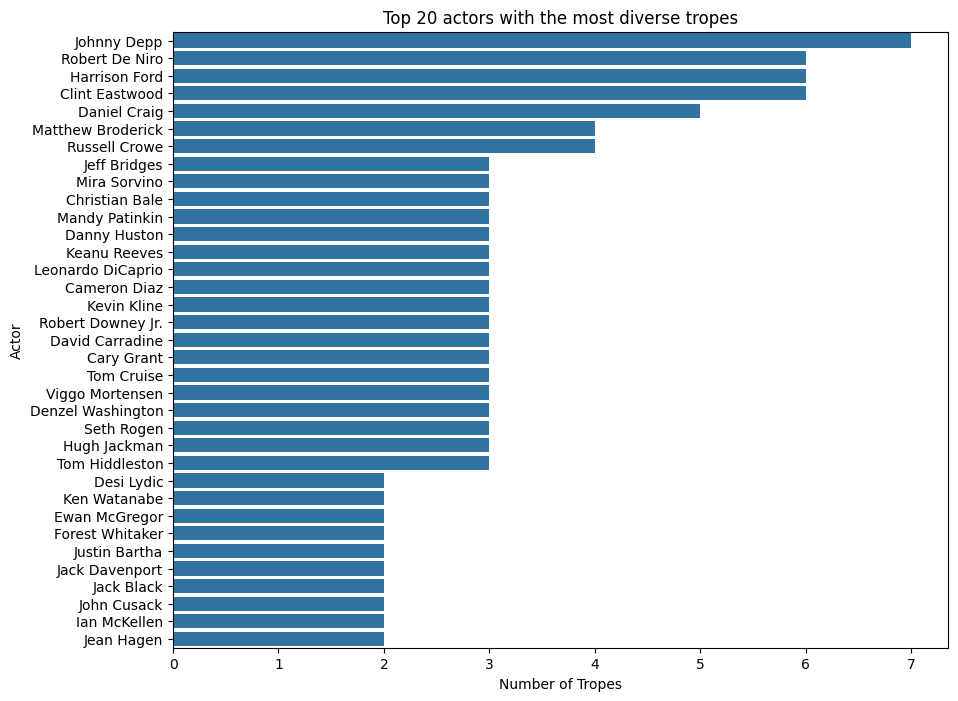

In [28]:
plt.figure(figsize=(10, 8))
sns.barplot(data = tvtropes_per_actor.head(35), x="num_tropes", y="actor", orient='h')
plt.xlabel('Number of Tropes')
plt.ylabel('Actor')
plt.title('Top 20 actors with the most diverse tropes')
plt.show()

As we can see we have a problem. We only have very few well known actors with multiple personas. This makes further analysis impossible with this dataset

### Analyse frequency of tropes when joined with our movies
This merging step is far from perfect as we have to merge on movie name, which is not a primary key. The generated data is widely unreliable, but we still plot it to get an idea of the distribution of personas.

In [33]:
tvtropes_personas_std = tvtropes_personas.copy()
tvtropes_personas_std['movie_name_standardized'] = tvtropes_personas_std['movie_name'].str.lower()

In [34]:
movies_std = movies.copy()
movies_std['movie_name_standardized'] = movies_std['movie_name'].str.lower()

In [35]:
movies_personas = movies_std.merge(tvtropes_personas_std, on='movie_name_standardized', how='inner')

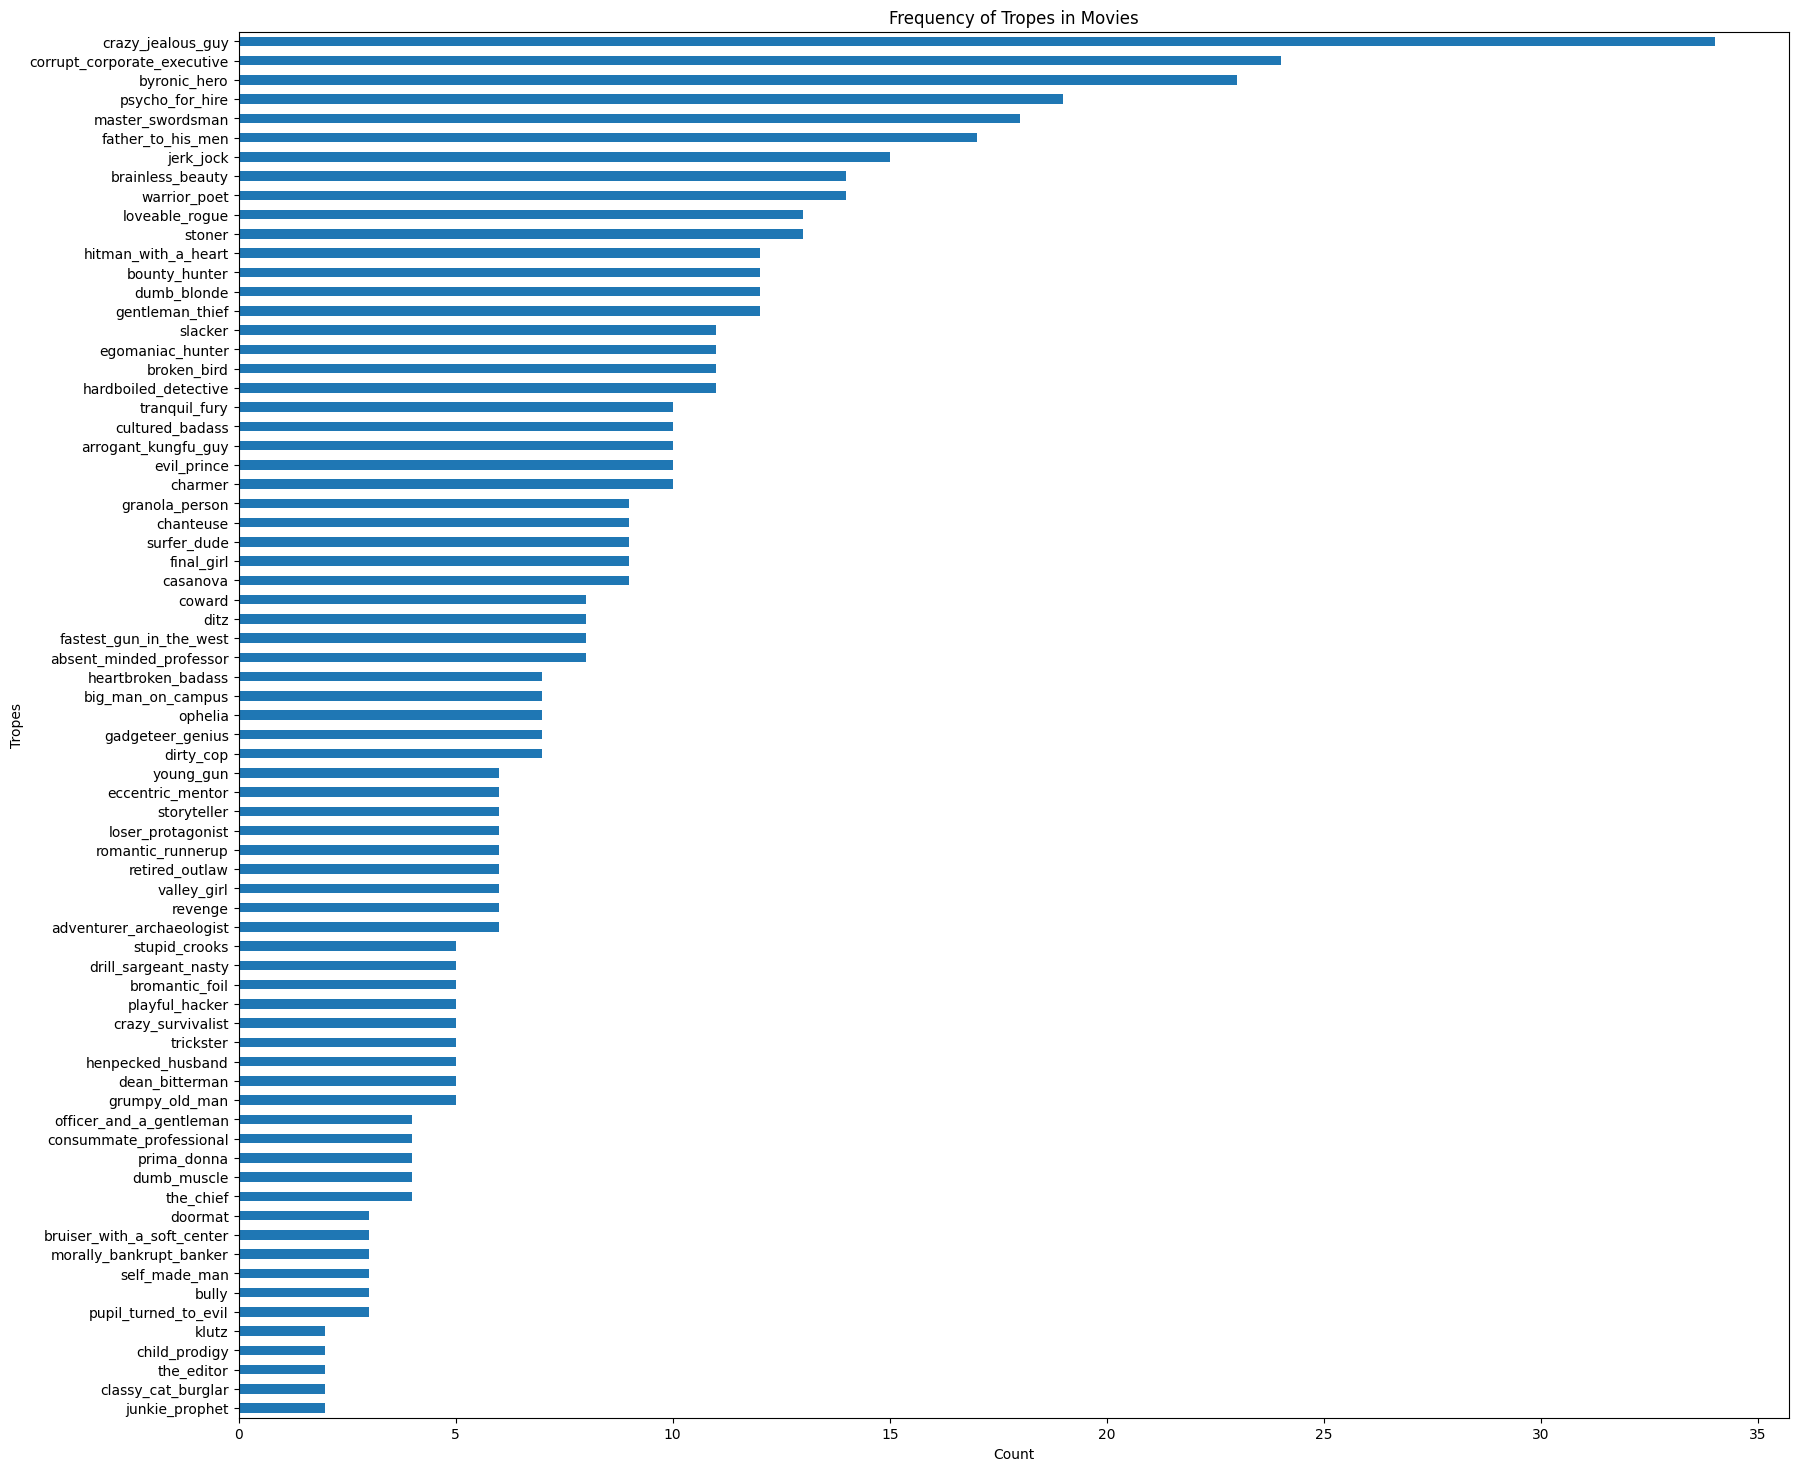

In [36]:
trope_value_counts = movies_personas['trope'].value_counts()

plt.figure(figsize=(20, 18))
trope_value_counts.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Tropes')
plt.title('Frequency of Tropes in Movies')
plt.gca().invert_yaxis()
plt.show()

## CMU personas with characters
We merge the actors and characters information we extracted in part I with the personas from the original paper

In [42]:
cmu_personas = load_personas()

In [43]:
cmu_personas.sample(5)

,freebase_id,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib
91889,e1,2796566,The Firm,he,he,8,23,"[0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.05, 0.0..."
48981,e15,19325619,Midnight Movie,friend,their awkward friend Sully,3,1,"[0.0, 0.69, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23, 0.0..."
89089,e3,27363241,Akasa Kusum,she,her,3,13,"[0.0, 0.0, 0.16, 0.05, 0.0, 0.01, 0.0, 0.0, 0...."
157319,e5,7000543,The Last Dragon,dragon,the young dragon,6,29,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
53424,e0,20211517,The Flower of Love,Raju,Raju,17,12,"[0.0, 0.0, 0.14, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [44]:
movies_personas_cmu = cmu_personas.merge(actors_characters, left_on='freebase_id', right_on='freebase_map_id')

In [45]:
movies_personas_cmu.sample(5)

,freebase_id_x,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib,nconst,knownForTitles,...,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
8033,/m/03lhdk7,4106181,Knock Off,Marcus Ray,Ray,4,35,"[0.0, 0.0, 0.0, 0.0, 0.01, 0.07, 0.0, 0.0, 0.0...",nm0000241,"tt1130988,tt0097659,tt0101764,tt0119013",...,1998-09-04,1960-10-18,M,1.78,/m/02p656s,Jean-Claude Van Damme,37.0,/m/03lhdk7,/m/05yxmct,/m/0m8_v
9147,/m/03jr4dp,5388717,I'm Not There,Arthur,Arthur,4,17,"[0.0, 0.0, 0.2, 0.0, 0.0, 0.01, 0.05, 0.0, 0.0...",nm0924210,"tt1074638,tt1371111,tt0396171,tt3464902",...,2007-09-03,1980-10-14,M,1.75,/m/02w7gg,Ben Whishaw,26.0,/m/03jr4dp,/m/0ct1p05,/m/05mk08
991,/m/03l17bv,12491754,Evil Angel,Carruthers,Carruthers ',3,35,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0000609,"tt0110912,tt2381249,tt0120755,tt0163988",...,2009,1959-05-12,M,1.83,/m/0x67,Ving Rhames,49.0,/m/03l17bv,/m/0h2cq0b,/m/032zg9
11541,/m/02vcb3s,9190913,Possessed,Mark Whitney,Mark talking with some politicians,12,49,"[0.0, 0.0, 0.05, 0.02, 0.0, 0.0, 0.02, 0.0, 0....",nm0000022,"tt0031381,tt0025316,tt0023382,tt0026752",...,1931-11-21,1901-02-01,M,1.85,None,Clark Gable,30.0,/m/02vcb3s,/m/0h2bzzm,/m/0bkmf
5051,/m/09tg9d1,24368095,The Dunwich Horror,Henry Armitage,Armitage and Cory,6,40,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0003225,"tt0056541,tt0050083,tt0061747,tt0061405",...,1970-01-14,1901-03-25,M,NaN,None,Ed Begley,68.0,/m/09tg9d1,/m/09tg9b_,/m/03bp_g


In [50]:
print(f"We have {len(movies_personas_cmu)} records for characters")

We have 11986 records for characters


This offers us one possiblity for further analysis, as we have more than 10'000 records

## Movie-based comfort zones
We investigate the possiblity of coming up with comfort zones by analysing movie features for a given actor

In [51]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,Romance,5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"Documentary,News,Sport",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"Action,Adventure,Biography",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",None
4,tt0000679,120,"Adventure,Fantasy",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",None


In [52]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,nm0000001,"tt0050419,tt0031983,tt0053137,tt0072308",tt0025164,"[""Guy Holden""]",/m/0glnm,61169,1934,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0,/m/0h953
1,nm0002143,"tt0036613,tt0030241,tt0027125,tt0057193",tt0025164,"[""Egbert 'Pinky' Fitzgerald""]",/m/0glnm,61169,1934,1886-03-18,M,NaN,None,Edward Everett Horton,NaN,/m/0cs6brt,None,/m/0197p7
2,nm0000001,"tt0050419,tt0031983,tt0053137,tt0072308",tt0026942,"[""Huck Haines""]",/m/02x5h46,12800555,1935-03-08,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z,/m/0h953
3,nm0000068,"tt0029284,tt0026942,tt0056412,tt0046375",tt0026942,"[""John Kent""]",/m/02x5h46,12800555,1935-03-08,1898-01-23,M,1.905,None,Randolph Scott,NaN,/m/03l20fw,/m/0h2qky5,/m/014y_c
4,nm0000001,"tt0050419,tt0031983,tt0053137,tt0072308",tt0027125,"[""Jerry Travers""]",/m/0gnjh,61501,1935,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5,/m/0h953


In [53]:
all_data = movies.merge(actors_characters, how="inner", on=["tconst", "freebase_id", "wiki_movie_id"])

In [54]:
all_data.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,...,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,tt0000574,70,"Action,Adventure,Biography",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,1871,M,NaN,None,John Tait,NaN,/m/0k6ktp,None,/m/0k6ksg
1,tt0000574,70,"Action,Adventure,Biography",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,1880,M,NaN,None,Nicholas Brierley,NaN,/m/0k6ktc,None,/m/0k6ks2
2,tt0000574,70,"Action,Adventure,Biography",6.0,855,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,\N,None,NaN,None,Norman Campbell,NaN,/m/0bxl4zk,None,/m/0bxl4z5
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,1907-06-20,\N,M,NaN,None,Henri Gouget,NaN,/m/0n5_12f,None,/m/0n5_12j
4,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,1907-06-20,1874-01-14,M,NaN,None,Georges Wague,NaN,/m/0n5_11r,None,/m/0n5_11v


In [55]:
all_data.columns

Index(['tconst', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'freebase_id', 'wiki_movie_id', 'movie_name', 'movie_release_date',
       'box_office', 'movie_languages', 'movie_countries', 'movie_genres',
       'plot_summary', 'nconst', 'knownForTitles', 'characters',
       'release_date', 'actor_birth', 'actor_gender', 'actor_height',
       'actor_ethnicity', 'actor_name', 'release_actor_age', 'freebase_map_id',
       'freebase_character_id', 'freebase_actor_id'],
      dtype='object')

### Based on movie genre

In [56]:
movie_genre_per_actor = all_data[["nconst", "actor_name", "movie_genres"]].copy()

In [57]:
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["movie_genres"].apply(lambda genres: list(genres.values()))

In [58]:
movie_genre_per_actor = movie_genre_per_actor.drop("movie_genres", axis=1)

In [59]:
movie_genre_per_actor = movie_genre_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()

In [60]:
movie_genre_per_actor["total_movies"] = movie_genre_per_actor["genres_flattened"].apply(len)

In [61]:
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: [item for row in ls for item in row])

In [62]:
movie_genre_per_actor["genres_freq"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: dict(sorted(dict(Counter(ls)).items(), key=lambda item: item[1], reverse=True)))

In [63]:
movie_genre_per_actor = movie_genre_per_actor.drop("genres_flattened", axis=1)

In [64]:
movie_genre_per_actor.head()

,nconst,actor_name,total_movies,genres_freq
0,nm0000001,Fred Astaire,33,"{'Musical': 28, 'Comedy': 20, 'Romance Film': ..."
1,nm0000004,John Belushi,6,"{'Comedy': 6, 'Action/Adventure': 3, 'Action':..."
2,nm0000007,Humphrey Bogart,68,"{'Drama': 52, 'Black-and-white': 41, 'Crime Fi..."
3,nm0000008,Marlon Brando,38,"{'Drama': 24, 'Romance Film': 9, 'Action/Adven..."
4,nm0000009,Richard Burton,48,"{'Drama': 37, 'Romance Film': 15, 'War film': ..."


#### Distribution of some actors

In [65]:
top_actors = movie_genre_per_actor.sort_values("total_movies", ascending=False).copy().head()

In [66]:
actor_1 = top_actors["genres_freq"].iloc[0]

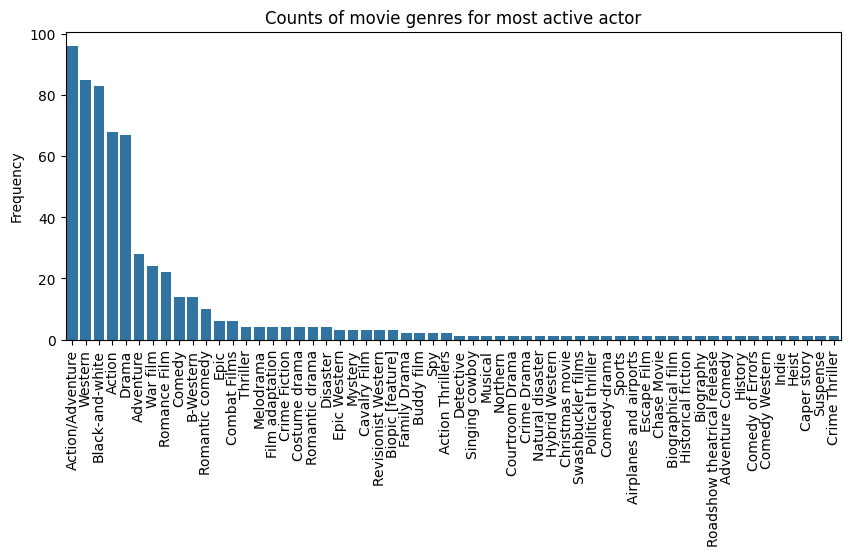

In [79]:
plt.figure(figsize=(10, 4))
plt.title('Counts of movie genres for most active actor')
sns.barplot(x=list(actor_1.keys()), y=list(actor_1.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [81]:
actor_2 = top_actors["genres_freq"].iloc[1]

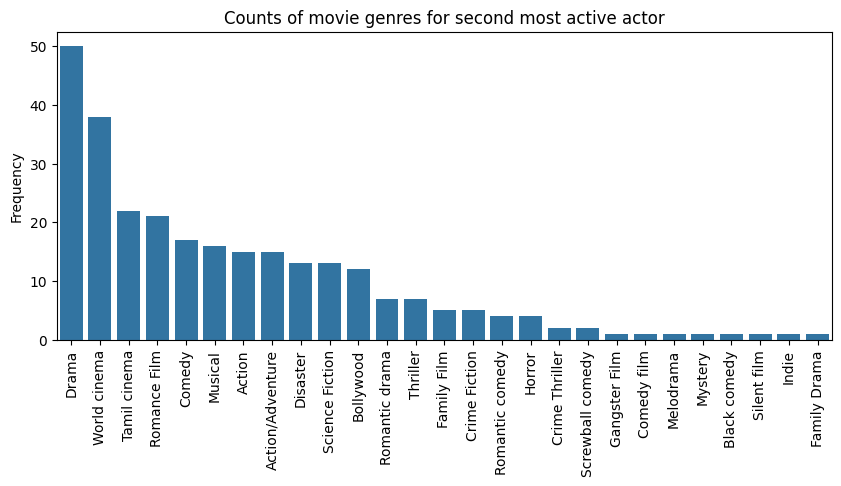

In [82]:
plt.figure(figsize=(10, 4))
plt.title('Counts of movie genres for second most active actor')
sns.barplot(x=list(actor_2.keys()), y=list(actor_2.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

### Based on runtime minutes

In [83]:
runtime_per_actor = all_data[["nconst", "actor_name", "runtimeMinutes"]].copy()

In [84]:
runtime_per_actor = runtime_per_actor[runtime_per_actor["runtimeMinutes"] != "\\N"]

In [85]:
runtime_per_actor = runtime_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()

In [86]:
runtime_per_actor["runtimeMinutes"] = runtime_per_actor["runtimeMinutes"].apply(lambda ls: list(map(lambda elem: int(elem), ls)))

In [87]:
runtime_per_actor['len'] = runtime_per_actor['runtimeMinutes'].apply(len)
runtime_per_actor = runtime_per_actor.sort_values(by='len', ascending=False).drop(columns='len')

#### Distribution of some actors

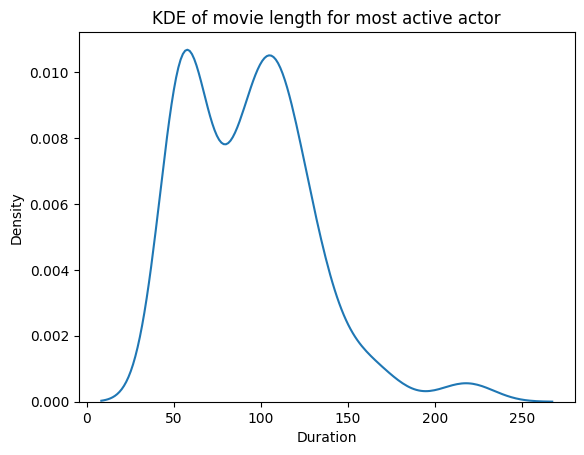

In [88]:
plt.title('KDE of movie length for most active actor')
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[0])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()

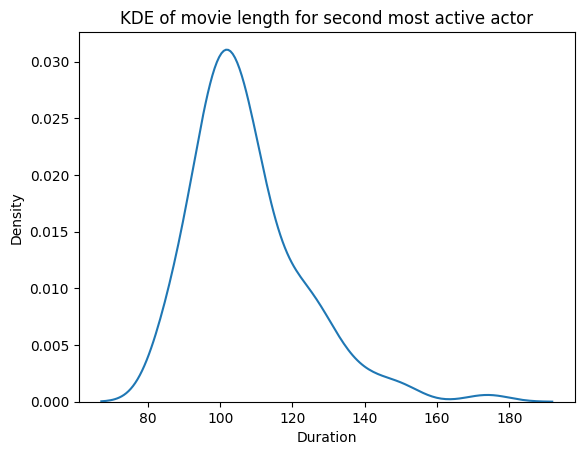

In [89]:
plt.title('KDE of movie length for second most active actor')
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[1])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()